# Tutorial 0: ZenML Quickstart

This tutorial demonstrates the complete workflow for training a model with ZenML
and visualizing the results.

**Why ZenML?** ZenML manages the entire ML pipeline lifecycle - it tracks
experiments, caches step outputs, and ensures reproducibility. By storing
artifacts (models, data, predictions) in ZenML, we can re-run training once
and then quickly iterate on analysis and visualization without re-training. 
It also supports easily adding on automatic parameter tuners like Optuna 
that we'll see in subsequent notebook examples.



In [1]:
import torch

from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines import quickstart_pipeline

# Initialize ZenML for notebook use
# setup_zenml_for_notebook automatically finds the project root by searching
# upward for .zen or .zenml directories, ensuring we use the root configuration.
# use_in_memory=True creates a temporary in-memory SQLite store, perfect for
# tutorials where we don't need persistent artifact storage.
zenml_client = zenml_utils.setup_zenml_for_notebook(use_in_memory=True)
print(f"ZenML initialized with stack: {zenml_client.active_stack_model.name}")



Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML initialized with stack: default


## Run the Training Pipeline

Here we execute the complete ZenML training pipeline. The pipeline consists of
several steps:

1. **build_datamodule**: Creates synthetic graph data and splits it into train/val sets
2. **build_module**: Instantiates the GroupClassifier model wrapped in a Lightning module
3. **train_module**: Trains the model using PyTorch Lightning (auto-detects CPU/GPU)
4. **collect_predictions**: Runs inference on the validation set to get predictions and targets

**Why use `enable_cache=False`?** This ensures the pipeline runs fresh each time,
which is useful for tutorials. In production, you'd typically enable caching to
skip re-running unchanged steps.

After the pipeline completes, we load the artifacts (trained model, datamodule,
predictions, targets) using `load_step_output`. These artifacts are stored by
ZenML and can be reloaded anytime without re-running the pipeline - this makes
notebooks fast and interactive.



In [2]:
run = quickstart_pipeline.with_options(enable_cache=False)()
print(f"Pipeline run status: {run.status}")

trained_module = load_step_output(run, "train_module")
datamodule = load_step_output(run, "build_datamodule")
predictions = load_step_output(run, "collect_predictions", index=0)
targets = load_step_output(run, "collect_predictions", index=1)

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the quickstart_pipeline run.")

trained_module.eval()
datamodule.setup(stage="fit")
device = next(trained_module.parameters()).device
print(f"Loaded artifacts from run {run.name} (device={device})")



Initiating a new run for the pipeline: quickstart_pipeline.
Registered new pipeline: quickstart_pipeline.
Caching is disabled by default for quickstart_pipeline.
Using user: default
Using stack: default
  deployer: default
  orchestrator: default
  artifact_store: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_datamodule has started.
Step build_datamodule has finished in 0.102s.
Step build_module has started.
Step build_module has finished in 0.079s.
Step train_module has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | GroupClassifier   | 1.1 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.522     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[train_module] /home/jack/virtual_environments/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=15 in the DataLoader` to improve performance.

[train_module] /home/jack/virtual_environments/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=15 in the DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Step train_module has finished in 1.140s.
Step collect_predictions has started.
Step collect_predictions has finished in 0.898s.
Pipeline run has finished in 3.057s.
Pipeline run status: completed
Loaded artifacts from run quickstart_pipeline-2025_11_25-22_58_41_678226 (device=cpu)


## Verify Predictions Were Collected

The `collect_predictions` step in the pipeline has already run inference and
collected predictions and targets. This cell simply verifies how many samples
were processed. The predictions are raw **logits** (model outputs *before* any sigmoid), and targets
are one-hot encoded class labels—both ready for evaluation metrics and plots.

A **logit** is the unnormalized score a model produces for each class. It is a real number
$( z \in (-\infty, \infty) )$ that becomes a probability only after applying a sigmoid:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

Positive logits correspond to probabilities above 0.5, negative logits correspond to probabilities below 0.5, and a logit of 0 maps to 0.5.

In [3]:
print(f"Collected predictions for {len(targets)} samples via pipeline step.")

Collected predictions for 64 samples via pipeline step.


# **Training Diagnostics Overview**

This section summarizes four core diagnostics produced during training: **Loss Curves**, **Confusion Matrices**, **ROC Curves**, and **Precision–Recall Curves**.
Each plot captures a different property of model behavior.

---


## **1. Loss Curves**

**Purpose:** Track optimization progress and generalization.

**How it's computed:**

* `train_epoch_loss_history`: average loss per training epoch
* `val_epoch_loss_history`: average loss per validation epoch

**Plot:**

* **X-axis:** epoch index
* **Y-axis:** loss value
* Two lines: Training loss vs. Validation loss.

**How to interpret:**

* **Both curves decreasing together:** normal learning.
* **Training ↓ but validation ↑:** overfitting.
* **Both curves flat:** optimization stuck (bad LR, architecture, data issues).
* **Large train–val gap:** high variance model or insufficient regularization.


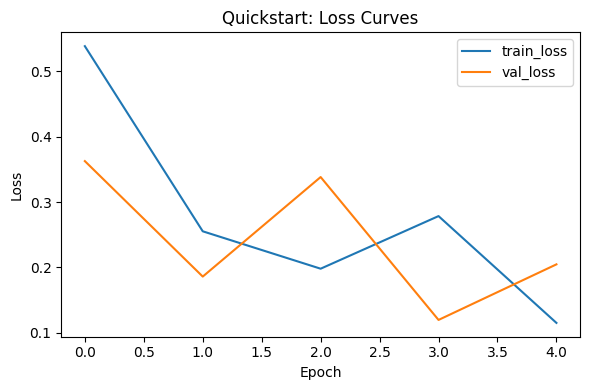

In [4]:
plot_loss_curves(trained_module, title="Quickstart: Loss Curves", show=True)

## **2. Multilabel Confusion Matrices**

**Purpose:** Evaluate binary classification quality for each class independently.

**How it's computed:**

* Apply `sigmoid` to logits.
* Threshold at **0.5** to get binary decisions.
* Compare predicted vs. true one-hot labels.
* Build a **2×2 confusion matrix per class**:

  * True Negative (TN)
  * False Positive (FP)
  * False Negative (FN)
  * True Positive (TP)

**Plot:**
Each class gets a small 2×2 heatmap (normalized so cells sum to 1).

**How to interpret:**

* **Strong diagonal (TN + TP dominant):** class is well-separated.
* **Bright FP cell:** model incorrectly predicts this class too often.
* **Bright FN cell:** model misses true instances of this class.
* **Upper–right or lower–left dominance:** strong bias toward predicting/not predicting the class.

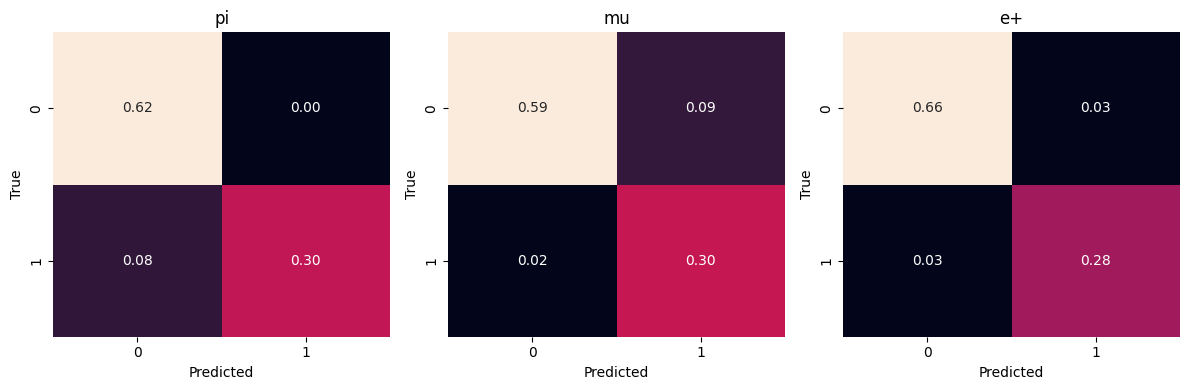

In [5]:
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    threshold=0.5,
    normalize=True,
    save_path=None,
    show=True,
)

## **3. Receiver Operating Characteristic (ROC) Curves**


The ROC curve evaluates a classifier’s **ranking quality** by sweeping the decision threshold across the full interval ([0,1]).

**1. Model scores and thresholding**

Assume the model outputs a score ( $s(x) \in [0,1]$ ) (typically a sigmoid-activated logit).

For any threshold ( $t \in [0,1]$ ):

$$
\hat{y}(x; t) =
\begin{cases}
1 & \text{if } s(x) \ge t \\
0 & \text{otherwise}
\end{cases}
$$

This induces a confusion matrix at each threshold:

* True Positives: ( TP(t) )
* False Positives: ( FP(t) )
* True Negatives: ( TN(t) )
* False Negatives: ( FN(t) )

---

**2. TPR and FPR as continuous functions of threshold**

Define the **True Positive Rate (Recall)** and **False Positive Rate** at threshold ( t ):
$$
\text{TPR}(t) = \frac{TP(t)}{TP(t) + FN(t)}
$$

$$
\text{FPR}(t) = \frac{FP(t)}{FP(t) + TN(t)}
$$

Both are piecewise-constant, right-continuous functions as a function of ( t ).

---

**3. ROC curve as a parametric curve**

The ROC curve is the parametric plot:

$$
\bigl( \text{FPR}(t),\ \text{TPR}(t) \bigr) \qquad \text{for } t \in [0,1]
$$

Typically we sweep ( t ) **from 1 down to 0**, because:

* At ( t = 1 ): all predictions are negative → point ((0,0)).
* At ( t = 0 ): all predictions are positive → point ((1,1)).

Thus the curve starts at the origin, climbs toward the top-left, and ends at ((1,1)).

---

**4. Sorting-based construction (practical implementation)**

Given (N) samples with scores ( s_i ) and labels ( y_i ):

1. Sort all samples by predicted score in descending order.
2. Sweep the threshold across each unique score.
3. At each threshold, update counts:

   * Adding a **positive** sample increases ( TP ) and thus TPR.
   * Adding a **negative** sample increases ( FP ) and thus FPR.
4. Emit the point:
    $$
   \left(
   \frac{FP}{FP + TN},
   \frac{TP}{TP + FN}
   \right)
   $$

This algorithmic view is equivalent to the parametric one above.

---

**5. Geometric interpretation**

* A model with perfect ranking produces a curve that rises immediately to ( (0,1) ) and then moves right to ( (1,1) ).

  $$
  \text{AUC} = 1
  $$

* A model with no ranking ability produces a diagonal line:
  $$
  \text{TPR}(t) = \text{FPR}(t)
  \quad\Rightarrow\quad
  \text{AUC} = 0.5
  $$

* A model worse than random lies below the diagonal (can be inverted; being consistently wrong is just as good as being consistently right!)

ROC is **invariant to class imbalance** because both TPR and FPR normalize by the size of their respective classes.

---

**6. Brief Summary**

**Purpose:** Measure the model’s ranking ability for each class.

**How it's computed:**

* Sweep a threshold across `[0, 1]` on `sigmoid(probabilities)`
* Compute:

  * **TPR = TP / (TP + FN)**
  * **FPR = FP / (FP + TN)**

**Plot:**

* **X-axis:** False Positive Rate
* **Y-axis:** True Positive Rate
* **AUC (Area Under Curve):** summary statistic for each class.

**How to interpret:**

* **Curve close to top-left + high AUC:** strong ranking quality.
* **Curve along diagonal:** random classifier.
* **Curves crossing:** instability or data scarcity for that class.

ROC is insensitive to class imbalance.

---

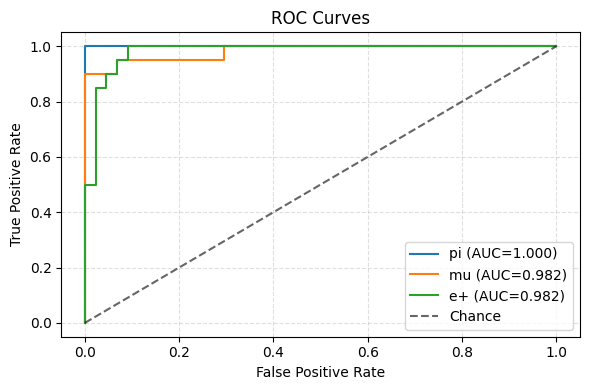

In [6]:
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    save_path=None,
    show=True,
)

## **4. Precision–Recall (PR) Curves**

The Precision–Recall curve evaluates a classifier’s **ability to correctly identify the positive class**, especially under **class imbalance** (one class is much more likely than the other in your dataset).
It is constructed by sweeping the decision threshold across the full interval ([0,1]), just like the ROC curve, but plotting Precision vs. Recall.

---

### **1. Model scores and thresholding**

Assume the model outputs a predicted probability or score
$$
s(x) \in [0,1].
$$

For any threshold ( $t \in [0,1]$ ):

$$
\hat{y}(x; t) =
\begin{cases}
1 & \text{if } s(x) \ge t \\
0 & \text{otherwise}
\end{cases}
$$

Each threshold produces a confusion matrix:

* True Positives: ( $TP(t)$ )
* False Positives: ( $FP(t)$ )
* False Negatives: ( $FN(t)$ )

Note that **TN is irrelevant** for PR curves.

---

### **2. Precision and Recall as functions of threshold**

Define:

$$
\text{Recall}(t) = \frac{TP(t)}{TP(t) + FN(t)}
$$

$$
\text{Precision}(t) = \frac{TP(t)}{TP(t) + FP(t)}
$$

Both are piecewise-constant, right-continuous functions of (t).
They change only when we cross a unique predicted score in the dataset.

---

## **3. PR curve as a parametric curve**

The Precision–Recall curve is the parametric plot

$$
\bigl( \text{Recall}(t),\ \text{Precision}(t) \bigr)
\qquad t \in [0, 1].
$$

We sweep the threshold (t) **from 1 down to 0**:


**Endpoint at (t=1): (Recall = 0, Precision = 1):**

At very high threshold, nothing is predicted positive:

* (TP = 0), (FP = 0)
* Recall (= 0/(P) = 0)
* Precision (= TP/(TP+FP)) is mathematically **undefined** (0/0)

**scikit-learn convention:**
`precision_recall_curve` **defines Precision = 1.0 when no positive predictions exist**.

This yields the first point **(Recall = 0, Precision = 1)**.

This point is *not* an empirical measurement — it’s a **continuity anchor** so every PR curve starts at the upper-left corner.


**Behavior as (t) decreases:**

Lowering the threshold causes more samples to be predicted positive. Each new sample updates the prefix counts:

* On a **positive** sample: ($TP = TP+1$)
* On a **negative** sample: ($FP = FP+1$)

Thus:

$$
\text{Recall}(t) = \frac{TP}{P},
\qquad
\text{Precision}(t) = \frac{TP}{TP + FP}.
$$

Recall **monotonically increases** from 0 to 1 as we encounter more positives.

Precision **moves up or down** depending on how many false positives are accumulated.


**Endpoint at (t=0): (Recall = 1, Precision = 0):**

At the lowest threshold, **everything is positive**:

* ($TP = P$) (all positives recovered)
* ($FP = N-P$) (all negatives falsely predicted)
* Recall ($= 1$)
* Precision ($= P / N_{total} = \text{prevalence}$)

**BUT:** scikit-learn again inserts an extra point:

`precision_recall_curve` **always appends a final point at precision = 0, recall = 1**
to formally close the curve. (see: [documentation](https://scikit-learn.sourceforge.net/dev/modules/generated/sklearn.metrics.precision_recall_curve.html))

Therefore you see:

* **True last empirical point:**
  $$
  (\text{Recall}=1,\ \text{Precision}=\text{prevalence})
  $$
* **scikit-learn-forced terminal point:**
` $$
  (1,\ 0)
  $$

This final (1, 0) ensures the curve meets the axes and forms a proper area for AP computation.

---

### **4. Sorting-based construction (practical implementation)**

Given model scores ( $s_i$ ) and binary labels ( $y_i \in {0,1}$ ):

1. **Sort** all samples by predicted score in **descending order**.

2. **Sweep** a threshold down through each unique score (equivalently: walk through the sorted list).

3. As you move down the ranked list, update counts:

   * If the next sample is **positive** ($y_i = 1$):
     $$
     TP = TP +  1
     $$

   * If the next sample is **negative** ($y_i = 0$):
     $$
     FP = FP +  1
     $$

4. After each update, compute:

$$
\text{Recall} = \frac{TP}{P},
\qquad
\text{Precision} = \frac{TP}{TP + FP}.
$$

Here:

* (TP) = number of true positives seen so far
* (FP) = number of false positives seen so far
* (P) = total number of actual positives in the dataset

This produces a sequence of ($\text{Recall}, \text{Precision}$) points that define the PR curve.


---

### **5. Geometric interpretation**

* A model with perfect ranking produces a curve that stays at:

  * **Precision = 1** until Recall reaches the total fraction of positives,
  * then drops sharply.

* A random classifier produces a flat line at:

$$
\text{Precision} = \frac{P}{P + N}
\quad\text{(the prevalence of the positive class)}
$$

* A model worse than random produces a curve that falls below the prevalence line.

**Unlike ROC**, the PR curve is **highly sensitive to class imbalance**:

* When positives are rare, even a few false positives dramatically reduce precision.
* This makes PR curves excellent for problems with rare events.

---

### **6. Area Under the PR Curve (AUPRC)**

AUPRC summarizes the curve:

$$
\text{AUPRC} = \int_0^1 \text{Precision}(\text{Recall}), d\text{Recall}
$$

Interpretation:

* High AUPRC → the model maintains high precision even as recall increases.
* Low AUPRC → model struggles to isolate positives.

Baseline (random classifier):

$$
\text{AUPRC}_\text{baseline} = \frac{P}{P + N}
$$

which is simply the fraction of positives in the dataset.


---

## **7. Average Precision (AP)**

Average Precision (AP) summarizes a Precision–Recall curve into a **single scalar score**, using a ranking-based definition rather than geometric integration.
It is the **standard metric** used in information retrieval, object detection challenges, and scikit-learn.


Given model scores ( $s_i \in [0,1]$ ) and binary labels ( $y_i \in {0,1}$ ):

1. Sort all samples by score in **descending** order.
2. As we move down the ranked list, compute precision at every point where recall increases.

Let $R_n$ be the recall after the ($n$)-th true positive,
and $P_n$ be the precision at that point.

The **Average Precision** is:

$$
[
\text{AP} = \sum_{n} \left( R_n - R_{n-1} \right) P_n
]
$$

This is a **discrete, ranking-based approximation** to the PR curve area.


> *“When the model predicts something as positive, how often is it correct, averaged across all recall levels?”*

Interpretation:

* **High AP:** model ranks true positives ahead of false positives.
* **Low AP:** predicted ranking is noisy; many FPs appear early.

 predictions.


### **8. Brief Summary**

**Purpose:** Evaluate performance on the positive class, especially under class imbalance.

**How it's computed:**

* Sweep a threshold across ([0,1])
* Compute:

  * **Recall = TP / (TP + FN)**
  * **Precision = TP / (TP + FP)**

**Plot:**

* **X-axis:** Recall
* **Y-axis:** Precision
* **AUPRC:** Summary statistic for positive-class quality.

**Interpretation:**

* **High, flat curve:** accurate identification of positives.
* **Curve collapsing at low recall:** many false positives early in the sweep.
* **Random baseline is the positive class prevalence.**

PR curves directly measure "How many of my predicted positives are correct?"
This is often more informative than ROC when positives are rare; i.e. most of your data is not the class you're looking for (ex. if you were looking to classify pions in a dataset of 99.99% electron hits).


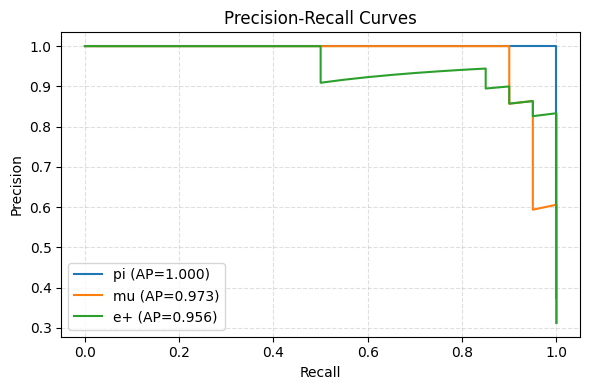

In [7]:
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    save_path=None,
    show=True,
)